#Assignment 1 - Chiebuka Onwuzurike.ipynb
The goal of this notebook is to show the possibilities of predicting financial outcomes from textual data via DistilBERT transformer model. 

This notebook builds on the next files: 

*   `company_des.csv` with company descriptions, see `2. Business Descriptions.ipynb` 
*   `ta.csv` and `rev.csv` with total assets and revenue data, see `3. YFinance Data.ipynb`

The steps this ipynb goes through are below: 

1.   Mount your Google Drive and establish the working directory. 
2.   Install and load the necessary libraries. 
3.   Load, merge, clean the data. 
4.   Create the label variable. 
5.   Prepare the predictor.  
6.   Run the DistilBERT model. 
7.   Train logistic regression and evaluate its accuracy.





# 1. Mount your Google Drive and establish the working directory

Mounting allows to access files on your Google Drive. You'll need to allow the Google Drive for desktop's access to your Google Account and copying the sign in code into the authorization code field. 

In [ ]:
# Mount Google Drive
from google.colab import drive
drive.mount('/content/gdrive/')

Mounted at /content/gdrive/


Set working directory to a Google Drive folder: change the `root_dir` to the folder on your Google Drive. 

`root_dir = "/content/gdrive/MyDrive/...`

In [ ]:
import os

# Set your working directory to a folder in your Google Drive. This way, if your notebook times out,
# your files will be saved in your Google Drive!

# the base Google Drive directory
root_dir = "/content/gdrive/MyDrive/M/MSBA - 5th Year/"

# choose where you want your project files to be saved
project_folder = "BA 870 - Financial and Accounting Analytics/"

def create_and_set_working_directory(project_folder):
  # check if your project folder exists. if not, it will be created.
  if os.path.isdir(root_dir + project_folder) == False:
    os.mkdir(root_dir + project_folder)
    print(root_dir + project_folder + ' did not exist but was created.')

  # change the OS to use your project folder as the working directory
  os.chdir(root_dir + project_folder)
  
  # create a test file to make sure it shows up in the right place
#   !touch 'new_file_in_working_directory.txt'
#   print('\nYour working directory was changed to ' + root_dir + project_folder + \
#         "\n\nAn empty text file was created there. You can also run !pwd to confirm the current working directory." )
create_and_set_working_directory(project_folder)

Check if the function worked by listing the files in the project folder. During the very first run it should contain only `new_file_in_working_directory.txt`. If you upload other files to your `project_folder`, other files will be listed too. 

In [ ]:
!ls

 assign1.csv
'Assignment #1 - Chiebuka Onwuzurike.ipynb'
'Business Descriptions.ipynb'
 new_file_in_working_directory.txt
 rev.csv
'Russell 3000 tickers.csv'
 stock_des.csv
 ta.csv
 tickers.csv
'Tickers Data.ipynb'
'Use DistilBERT to Predict Asset Intensity with Business Description.ipynb'
'YFinance Data.ipynb'


Please upload the necessary files (`stock_des.csv`, `ta.csv`, `rev.csv`) in your `project_folder` folder. 

You can upload the files in your Google Drive `project_folder` via drive.google.com or via below `files.upload()` button. 

In [ ]:
# # Upload data
# from google.colab import files
# uploaded = files.upload()

# 2. Install, load the libraries

In [ ]:
!pip install transformers

In [ ]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

import torch

import transformers as ppb # pytorch transformers

from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import train_test_split

from sklearn import metrics


# 2. Load, merge, clean the data

In [ ]:
# load the csv files
stock_des = pd.read_csv('stock_des.csv')
ta = pd.read_csv('ta.csv')
rev = pd.read_csv('rev.csv')
assign1 =pd.read_csv("assign1.csv")

In [ ]:
# clean up the column names 
ta.rename(columns={'Unnamed: 0': 'ticker'}, inplace=True)
rev.rename(columns={'Unnamed: 0': 'ticker'}, inplace=True)
assign1.rename(columns={'tic': 'ticker'}, inplace=True)

In [ ]:
# merge the dataframes into one
df = pd.merge(ta, rev, on='ticker')
df = pd.merge(df, stock_des, on='ticker')
df2 = pd.merge(stock_des, assign1, on='ticker')

In [ ]:
# remove the observations with ta and rev less than 10000 
print(df.shape)
df = df[(df['Total Assets'] >= 10000) & (df['Total Revenue'] >= 10000)]
print(df.shape)

(2830, 4)
(2719, 4)


In [ ]:
# remove the observations with ta and rev less than 10000 
# print(df2.shape)
# df2 = df2[df2['sale'] >= 10]
# print(df2.shape)

In [ ]:
# create the assets to revenue ratio 
df['ar_ratio'] = df['Total Assets']/df['Total Revenue']
print(df['ar_ratio'].describe())

count     2719.000000
mean        22.795845
std        386.905317
min          0.134677
25%          1.242993
50%          2.239040
75%          7.051726
max      18819.875000
Name: ar_ratio, dtype: float64


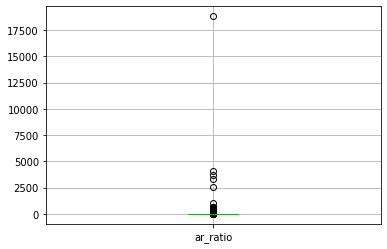

In [ ]:
df.boxplot(column='ar_ratio')

We have 6 outliers with the ratio of 1000+. Let's remove them. 

In [ ]:
print(df.shape)
df = df[df['ar_ratio']<1000]
print(df.shape)

(2719, 5)
(2713, 5)


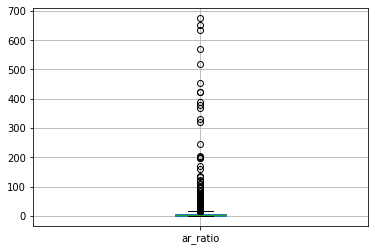

In [ ]:
df.boxplot(column='ar_ratio')

In [ ]:
# create the assets to revenue ratio 
df2['rd_intensity'] = df2['xrd']/df2['sale']
print(df2['rd_intensity'].describe())

count    2776.000000
mean             inf
std              NaN
min         0.000000
25%         0.000000
50%         0.000000
75%         0.085514
max              inf
Name: rd_intensity, dtype: float64


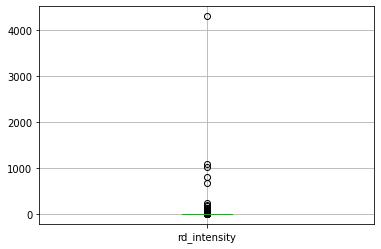

In [ ]:
df2.boxplot(column='rd_intensity')

We have 96 outliers with the ratio of 300+. Let's remove them.

In [ ]:
# print(df2.shape)
# df2 = df2[df2['rd_intensity']<300]
# print(df2.shape)

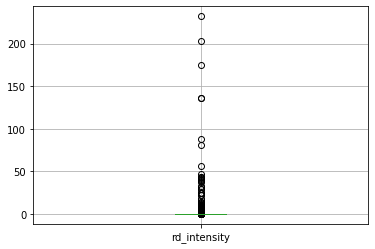

In [ ]:
df2.boxplot(column='rd_intensity')

Due to Colab's RAM limitations, limit the description size. We allow 350 characters, which is approximately 50 words and 3+ sentences. In case if you still face RAM issues try terminating other Colab notebooks (Runtime > Manage sessions) or reducing the characters to 300. 

In [ ]:
df['description'] = df['description'].str.slice(0,350)
df2['description'] = df2['description'].str.slice(0,350)

Create a binary variable that is 1 if the assets to revenue ratio is above its median and 0 otherwise. 

This is the **dependent variable** (label) that we'll try to predict. 

In [ ]:
df['HIGH_ARR'] = (df['ar_ratio'].gt(df['ar_ratio'].median())).astype(int)
df2['HIGH_INNOVATION'] = (df2['rd_intensity'].gt(df2['rd_intensity'].median())).astype(int)

Note: The gt() method of DataFrame class, compares elements of a pandas DataFrame instance with another DataFrame instance. If the element from the first DataFrame is greater than the element from the second DataFrame, gt() returns True in the resultant DataFrame.



In [ ]:
df.sample(5)

,ticker,Total Assets,Total Revenue,description,ar_ratio,HIGH_ARR
1847,OFIX,5.258610e+08,4.065620e+08,Orthofix Medical Inc. operates as a medical de...,1.293434,0
261,AVGO,7.593300e+10,2.388800e+10,"Broadcom Inc. designs, develops, and supplies ...",3.178709,1
2176,ROLL,1.321912e+09,7.274610e+08,RBC Bearings Incorporated manufactures and mar...,1.817159,0
2707,WAL,3.646100e+10,1.114100e+09,Western Alliance Bancorporation operates as th...,32.726865,1
1201,HLF,3.076100e+09,5.541800e+09,Herbalife Nutrition Ltd. offers nutrition solu...,0.555072,0


In [ ]:
df2.sample(5)

,ticker,description,sale,xrd,rd_intensity,HIGH_INNOVATION
2054,KOP,Koppers Holdings Inc. provides treated wood pr...,1669.100,0.000,0.000000,0
1474,MHO,"M/I Homes, Inc., together with its subsidiarie...",3046.345,0.000,0.000000,0
2577,ESCA,"Escalade, Incorporated, together with its subs...",273.649,1.500,0.005481,1
2147,TMST,TimkenSteel Corporation manufactures and sells...,830.700,1.800,0.002167,1
1916,PLOW,"Douglas Dynamics, Inc. operates as a manufactu...",480.154,6.679,0.013910,1


# Preparing the predictor and DistilBERT model

**Note**. Please enable GPU in Edit > Notebook settings > Hardware accelerator. 

Load a pre-trained BERT model.

In [ ]:
model_class, tokenizer_class, pretrained_weights = (ppb.DistilBertModel, ppb.DistilBertTokenizer, 'distilbert-base-uncased')

# Load pretrained model/tokenizer
tokenizer = tokenizer_class.from_pretrained(pretrained_weights)
model = model_class.from_pretrained(pretrained_weights)

Some weights of the model checkpoint at distilbert-base-uncased were not used when initializing DistilBertModel: ['vocab_layer_norm.weight', 'vocab_transform.weight', 'vocab_transform.bias', 'vocab_projector.bias', 'vocab_projector.weight', 'vocab_layer_norm.bias']
- This IS expected if you are initializing DistilBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DistilBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Tokenize the textual data for DistilBERT. 

In [ ]:
tokenized = df['description'].apply((lambda x: tokenizer.encode(x, add_special_tokens=True)))
tokenized2 = df2['description'].apply((lambda x: tokenizer.encode(x, add_special_tokens=True)))

Pad all lists of tokenized values to the same size. 

In [ ]:
max_len = 0
for i in tokenized.values:
    if len(i) > max_len:
        max_len = len(i)

padded = np.array([i + [0]*(max_len-len(i)) for i in tokenized.values])

max_len = 0
for i in tokenized2.values:
    if len(i) > max_len:
        max_len = len(i)

padded2 = np.array([i + [0]*(max_len-len(i)) for i in tokenized2.values])

In [ ]:
np.array(padded).shape
np.array(padded2).shape

(2680, 109)

Create attention mask variable for BERT to ignore (mask) the padding when it's processing its input.

In [ ]:
attention_mask = np.where(padded != 0, 1, 0)
attention_mask.shape

attention_mask2 = np.where(padded2 != 0, 1, 0)
attention_mask2.shape

(2680, 109)

# DistilBERT model

We run the pretrained DistilBERT model on the prepared predictor and keep the result in `last_hidden_states` variable. 

In [ ]:
input_ids = torch.tensor(padded)  
attention_mask = torch.tensor(attention_mask)

with torch.no_grad():
    last_hidden_states = model(input_ids, attention_mask=attention_mask)

# Logistic regression model 



Keep the first layer of the hidden states and assign the outcome variable to `labels`. 

In [ ]:
features = last_hidden_states[0][:,0,:].numpy()
labels = df['HIGH_ARR']

Split the data in train and test subsets, train the Logistic Regression on train set and evaluate its accuracy on the test set. 

In [ ]:
train_features, test_features, train_labels, test_labels = train_test_split(features, labels)
lr_clf = LogisticRegression(max_iter=5000)
lr_clf.fit(train_features, train_labels)
print(lr_clf.score(test_features, test_labels))

0.8217967599410898


Check if this approach works better than a random guess (0.8 > 0.5). 

In [ ]:
from sklearn.dummy import DummyClassifier
clf = DummyClassifier()

scores = cross_val_score(clf, train_features, train_labels)
print("Dummy classifier score: %0.3f (+/- %0.2f)" % (scores.mean(), scores.std() * 2))

Dummy classifier score: 0.492 (+/- 0.05)


/usr/local/lib/python3.7/dist-packages/sklearn/dummy.py:132: FutureWarning: The default value of strategy will change from stratified to prior in 0.24.
  "stratified to prior in 0.24.", FutureWarning)


# DistilBERT model 2

We run the pretrained DistilBERT model on the prepared predictor and keep the result in `last_hidden_states` variable. 

In [ ]:
input_ids2 = torch.tensor(padded2)  
attention_mask2 = torch.tensor(attention_mask2)

with torch.no_grad():
    last_hidden_states2 = model(input_ids2, attention_mask=attention_mask2)

# Logistic regression model 2



Keep the first layer of the hidden states and assign the outcome variable to `labels`. 

In [ ]:
features2 = last_hidden_states2[0][:,0,:].numpy()
labels2 = df2['HIGH_INNOVATION']

Split the data in train and test subsets, train the Logistic Regression on train set and evaluate its accuracy on the test set. 

In [ ]:
train_features2, test_features2, train_labels2, test_labels2 = train_test_split(features2, labels2)
lr_clf2 = LogisticRegression(max_iter=5000)
lr_clf2.fit(train_features2, train_labels2)
print(lr_clf2.score(test_features2, test_labels2))

0.9044776119402985


Check if this approach works better than a random guess (0.8 > 0.5). 

In [ ]:
from sklearn.dummy import DummyClassifier
clf = DummyClassifier()
scores = cross_val_score(clf, train_features2, train_labels2)
print("Dummy classifier score: %0.3f (+/- %0.2f)" % (scores.mean(), scores.std() * 2))

Dummy classifier score: 0.503 (+/- 0.02)


/usr/local/lib/python3.7/dist-packages/sklearn/dummy.py:132: FutureWarning: The default value of strategy will change from stratified to prior in 0.24.
  "stratified to prior in 0.24.", FutureWarning)


# Confusion Matrix

In [ ]:
# Reference https://en.wikipedia.org/wiki/Confusion_matrix
def confusion_print(matrix_crosstab):
    P = matrix_crosstab.iloc[1,2] # all positives
    N = matrix_crosstab.iloc[0,2] # all negatives
    TP = matrix_crosstab.iloc[1,1] # true positives
    TN = matrix_crosstab.iloc[0,0] # true negatives
    FP = matrix_crosstab.iloc[0,1] # false positives
    FN = matrix_crosstab.iloc[1,0] # false negatives
    TPR = TP/P # true positive rate
    TNR = TN/N # true negative rate
    PPV = TP/(TP+FP) # positive prediction value or precision
    NPV = TN/(TN+FN) # negative prediction value
    FNR = FN/P # false negative rate or miss rate
    FPR = FP/N # false positive rate or fall out
    FDR = FP/(TP+FP) # false discovery rate
    FOR = FN/(TN+FN) # false omission rate
    ACCURACRY = (TP+TN)/(P+N)
    F1 = 2 * (PPV * TPR)/(PPV + TPR)

    print(f"""
    All positives: {P}
    All negatives: {N}
    True positives: {TP}
    True negatives: {TN}
    False positives: {FP}
    False negatives: {FN}

    Sensitivity | True positive rate: {TPR}
    Specificity | True negative rate: {TNR}
    Precision | Positive prediction value: {PPV}
    Negative prediction value: {NPV}
    Miss-rate | False negative rate: {FNR}
    Fall-out | False positive rate: {FPR}
    False discovery rate: {FDR}
    False omission rate: {FOR}

    Accuracy: {ACCURACRY}
    F1: {F1}
    """)

## HIGH_ARR Model 1

In [ ]:
actual = lr_clf.predict(test_features)
predicted = np.array(test_labels) 
data = {'actual': actual,'predicted': predicted}
df_cross = pd.DataFrame(data)
confusion_matrix = pd.crosstab(df_cross['actual'], df_cross['predicted'], rownames=['Actual'], colnames=['Predicted'], margins = True)
confusion_print(confusion_matrix)


    All positives: 344
    All negatives: 335
    True positives: 286
    True negatives: 272
    False positives: 63
    False negatives: 58

    Sensitivity | True positive rate: 0.8313953488372093
    Specificity | True negative rate: 0.8119402985074626
    Precision | Positive prediction value: 0.8194842406876791
    Negative prediction value: 0.8242424242424242
    Miss-rate | False negative rate: 0.1686046511627907
    Fall-out | False positive rate: 0.1880597014925373
    False discovery rate: 0.18051575931232092
    False omission rate: 0.17575757575757575

    Accuracy: 0.8217967599410898
    F1: 0.8253968253968255
    


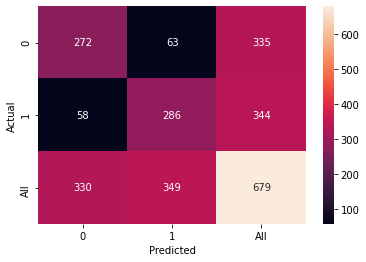

In [ ]:
sns.heatmap(confusion_matrix, annot=True, fmt=".5g")
plt.show()

## HIGH_INNOVATION Model 2

In [ ]:
actual2 = lr_clf2.predict(test_features2)
predicted2 = np.array(test_labels2)
data = {'actual': actual2,'predicted': predicted2}
df_cross2 = pd.DataFrame(data)
confusion_matrix2 = pd.crosstab(df_cross2['actual'], df_cross2['predicted'], rownames=['Actual'], colnames=['Predicted'], margins = True)
confusion_print(confusion_matrix)


    All positives: 344
    All negatives: 335
    True positives: 286
    True negatives: 272
    False positives: 63
    False negatives: 58

    Sensitivity | True positive rate: 0.8313953488372093
    Specificity | True negative rate: 0.8119402985074626
    Precision | Positive prediction value: 0.8194842406876791
    Negative prediction value: 0.8242424242424242
    Miss-rate | False negative rate: 0.1686046511627907
    Fall-out | False positive rate: 0.1880597014925373
    False discovery rate: 0.18051575931232092
    False omission rate: 0.17575757575757575

    Accuracy: 0.8217967599410898
    F1: 0.8253968253968255
    


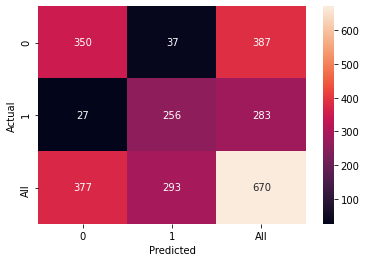

In [ ]:


sns.heatmap(confusion_matrix2, annot=True, fmt=".5g")
plt.show()

## Results


Looking at metrics for the first model such as the sensitivity, specificity, percision, accuracy, and F1 are all slightly above 80% which is a good sign of the model.

Looking at metrics for the second model such as the sensitivity, specificity, percision, accuracy, and F1 are all around 90% which is a really sign.

Model 2 was better than model 1.

Our model could have been better in a few ways:

1.) If we were able to use a longer description than 350 characters

2.) If we used a different instead of the median for the cut off for binary classification

3.) If we used cross fold valuations to use all the observation for training and testing

4.) If we sommehow imporved our neuro-network

Overall greatly impressed by the models use of text. I hypothesis the second model was better at predicting because there are many varation for assets such as inventory, PPE, ect. Additionally companies that are high in innovation will often say it because it is highly tied to their strategy and competivive advantage.